# Worksheet 17

Name:  Wanchen Hong
UID: U72264072

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

There is likely an imbalance between like and dislike, so I would build a recommender system that is user-based. So I will try to model the similarity between users from the movies they watch and the movies they like and recommend them the movies that similar users like.

b) Describe 3 challenges of building a recommender system

1) how the rating might change over time 2) not full data for each movie and user pair 3) users would interact with their ratings differently.

c) Why is SVD not an option for collaborative filtering?

Because the matrix is sparse, and thus not able to decompose effectively.

d) Use the code below to train a recommender system on a dataset of amazon movies

In [26]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("/train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="nan",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
        # als.rank, [10, 50]).addGrid(
        # als.regParam, [.1]).addGrid(
        # # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
        # metricName="rmse",
        # labelCol="Score",
        # # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()

Kaggle RMSE =  3.2269490234585363


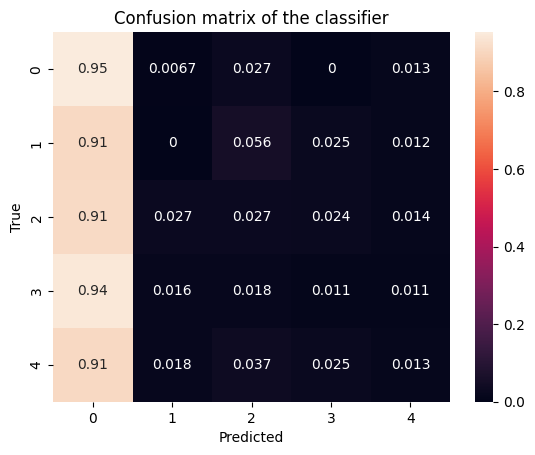

In [36]:
X_test_processed['Score'] = rec['prediction'].values.reshape(-1, 1)
X_test_processed['Score'] = X_test_processed['Score'].fillna(0)

def assign_factor(value):
    if value <= 0.5:
        return 1
    elif value <= 1:
        return 2
    elif value <= 1.5:
        return 3
    elif value <= 2:
        return 4
    else:
        return 5

X_test_processed['Score'] = X_test_processed['Score'].apply(assign_factor)

print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()